In [38]:
import numpy as np
import pandas as pd
X_train_fpath = './X_train'
Y_train_fpath = './Y_train'
X_test_fpath = './X_test'
output_fpath = 'output_logistic.csv'
X_train = np.genfromtxt(X_train_fpath, delimiter=',', skip_header=1)
Y_train = np.genfromtxt(Y_train_fpath, delimiter=',', skip_header=1)

In [39]:
X_train.shape ,Y_train.shape

((32561, 106), (32561,))

In [40]:
X_train

array([[3.90000e+01, 7.75160e+04, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.00000e+01, 8.33110e+04, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.80000e+01, 2.15646e+05, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [5.80000e+01, 1.51910e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.20000e+01, 2.01490e+05, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.20000e+01, 2.87927e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [41]:
Y_train

array([0., 0., 0., ..., 0., 0., 1.])

In [42]:
def _normalize_column_0_1(X, train=True, specified_column = None, X_min = None, X_max=None):
    # The output of the function will make the specified column of the training data 
    # from 0 to 1
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the max value of the 
    # training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_max = np.reshape(np.max(X[:, specified_column], 0), (1, length))
        X_min = np.reshape(np.min(X[:, specified_column], 0), (1, length))
        
    X[:, specified_column] = np.divide(np.subtract(X[:, specified_column], X_min), np.subtract(X_max, X_min))

    return X, X_max, X_min

def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    # The output of the function will make the specified column number to 
    # become a Normal distribution
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the mean value and 
    # the variance of the training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
        X_std  = np.reshape(np.std(X[:, specified_column], 0), (1, length))
    
    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
     
    return X, X_mean, X_std


def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])
    
def train_dev_split(X, y, dev_size=0.25):
    train_len = int(round(len(X)*(1-dev_size)))
    return X[0:train_len], y[0:train_len], X[train_len:None], y[train_len:None]

In [43]:
def _sigmoid(z):
    # sigmoid function can be used to output probability
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)

def get_prob(X, w, b):
    # the probability to output 1
    return _sigmoid(np.add(np.matmul(X, w), b))

def infer(X, w, b):
    # use round to infer the result
    return np.round(get_prob(X, w, b))

def _cross_entropy(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)+lamda*w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _loss(y_pred, Y_label, lamda, w):
    return _cross_entropy(y_pred, Y_label) + lamda * np.sum(np.square(w))
def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc


In [44]:
def train(X_train, Y_train):
    # split a validation set
    dev_size = 0.1155
    X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)
    
    # Use 0 + 0*x1 + 0*x2 + ... for weight initialization
    w = np.zeros((X_train.shape[1],)) 
    b = np.zeros((1,))

    regularize = True
    if regularize:
        lamda = 0.001
    else:
        lamda = 0
    
    max_iter = 40  # max iteration number
    batch_size = 32 # number to feed in the model for average to avoid bias
    learning_rate = 0.2  # how much the model learn for each step
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    step =1

    loss_train = []
    loss_validation = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(max_iter):
        # Random shuffle for each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)
        
        total_loss = 0.0
        # Logistic regression train with batch
        for idx in range(int(np.floor(len(Y_train)/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]
            
            # Find out the gradient of the loss
            #w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)
            w_grad, b_grad = _gradient(X, Y, w, b)
            
            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad
            
            step = step+1
            
        # Compute the loss and the accuracy of the training set and the validation set
        y_train_pred = get_prob(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)
        
        y_dev_pred = get_prob(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(accuracy(Y_dev_pred, Y_dev))
        loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)
    
    return w, b, loss_train, loss_validation, train_acc, dev_acc  # return loss for plotting

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
# return loss is to plot the result
col = [0,1,3,4,5,7,10,12,25,26,27,28]
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)
w, b, loss_train, loss_validation, train_acc, dev_acc= train(X_train, Y_train)

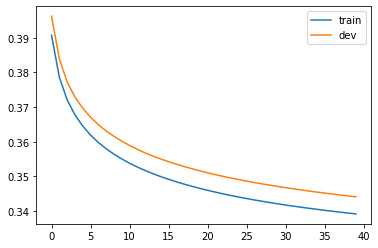

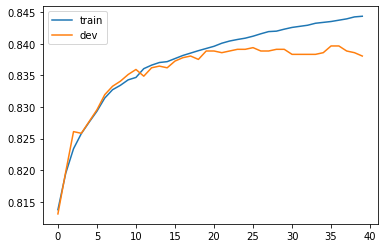

In [47]:
plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()

In [48]:
X_test = np.genfromtxt(X_test_fpath, delimiter=',', skip_header=1)
# Do the same data process to the test data
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

In [49]:
result = infer(X_test, w, b)


In [50]:
with open(output_fpath, 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(result):
            f.write('%d,%d\n' %(i+1, v))

In [51]:
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().rstrip('\n')
features = np.array([x for x in content.split(',')])
for i in ind[0:10]:
    print(features[i], w[i])

capital_gain 1.3211947224784186
 Never-married -0.8113834031218152
 Married-civ-spouse 0.7231730973302497
 Bachelors 0.588299174415565
 Own-child -0.5658239661661122
 Other-service -0.507541212944714
 Exec-managerial 0.5044929642620795
 Unmarried -0.5010477535159267
 Not-in-family -0.4446996325830085
 Wife 0.41757607562979526
